# CS145: Project 3 | Predicting Taxi Trip Tip Percentage in New York

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Jingxi Cai, harvec*
* *Kaile JIN, kailejin*

# Project Overview

---

In this project, we analyzed the BigQuery dataset *new_york_taxi_trips* , which contains information on the total amount of a taxi trip for different taxies in different year. Additionally, the corresponding trip inforamtion is also provided, like the pickup time and location, dropoff time and location, the number of passengers, trip distance, base fares, taxi colors are also provided.


The central question of this project is: Can we predict the tip percentage of a taxi trip based on factors such as time, zone, the number of passengers, trip distance, base fares, taxi colors, etc...


To approach this question, we first set out to answer the following supplementary questions in order to determine the best features to use to predict tip amount:
*   What is the correlation between the trip time and the tip percentage?
*   What is the correlation between the trip distance and the tip percentage?
*   What is the correlation between the trip speed and the tip percentage?
*   What is the correlation between the taxi color and the tip percentage?
*   What is the correlation between the pickup borough and dropoff boroughn with the tip percentage? 
*   What is the correlation between the passenger number and the tip percentage? 
*   What is the correlation between the season and the tip percentage? 
*   What is the correlation between the trip type and the tip percentage? 

---


# Analysis of Dataset

---
Our dataset is *new_york_taxi_trips* , which contains information about the taxi trips in New York. The tables included are:

*   taxi_zone_geom: 2.49 MB -- This table contains the zone id,zone_name, borough and the	Geometric outline of zone.
*   *   Primary key: zone_name
*   *   Foreign key: zone_id
*   tlc_fhv_trips_2015: 3.12 GB -- The year of this taboe is too early and the number of features is small, so we didn't use it.
*   tlc_fhv_trips_2016: 6.33 GB -- The same reason as above.
*   tlc_fhv_trips_2017: 15.62 GB -- The same reason as above.
*   tlc_green_trips_2014: 2.08 GB -- The year of this taboe is too early, so we didn't use it.
*   tlc_green_trips_2015: 2.69 GB -- The same reason as above.
*   tlc_green_trips_2016: 1.27 GB -- TThe same reason as above.
*   tlc_green_trips_2017: 1.91 GB -- The same reason as above.
*   tlc_green_trips_2018: 1.91 GB -- This is the main table contains trip information about green taxi. We are trying to measure how various features within this table (like time, zone, the number of passengers, trip distance, base fares, taxi colors) affect tip amount.
*   *   Primary key: pickup_datetime
*   *   Foreign key: zone_id
*   tlc_yellow_trips_2015: 18.07 GB -- The year of this taboe is too early, so we didn't use it.
*   tlc_yellow_trips_2016: 17.48 GB -- The same reason as above.
*   tlc_yellow_trips_2017: 18.35 GB -- The same reason as above.
*   tlc_yellow_trips_2018: 18.14 GB -- This is the table we use to measure the correlation between taxi colors(green, yellow) and the tip amount.
*   *   Primary key: pickup_datetime
*   *   Foreign key: zone_id

As mentioned, we  explored the relationship between the relationship between the number of regions geo-targeted by the advertiser and the number of impressions. We joined *tlc_green_trips_2018* and *taxi_zone_geom* on the foreign key *zone_id* to relate these two tables.

Beyond, we explored the relationship between various features and tip amount. We randomly choose 1000 data from *tlc_green_trips_2018* and *tlc_green_trips_2018* to compare the tip amount.

----

---
# Data Exploration
---

Initialization of BigQuery and Matplotlib

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "my-project-ml-331322"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
import matplotlib.pyplot as plt
import pandas
%matplotlib inline

### 1. Trip Time vs. Tip Percentage

We analyzed the correlation between the length of trip time and the tip percentage in the *tlc_green_trips_2018* table.

After plotting the results of our query, we see that with the trip time increase, the tip percentage first decrease, then increase, finally decrease. It seems that there is some possible correlation between trip time and tip percentage.

We draw the bar plot and scatter plot to see which can show the more intuitive information.

* Bar plot 

In [ ]:
%%bigquery --project $project_id a0a

SELECT
  (CASE
      WHEN time_length BETWEEN 0 AND 50 THEN 1
      WHEN time_length BETWEEN 50 AND 100 THEN 2
      WHEN time_length BETWEEN 100 AND 150 THEN 3
      WHEN time_length BETWEEN 150 AND 200 THEN 4
      ELSE 5
      END
      ) AS label,
  AVG(tip_percentage) AS tip_percentage
FROM (
  SELECT
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS time_length,
    tip_amount/fare_amount AS tip_percentage
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` TABLESAMPLE SYSTEM(0.01 PERCENT)
  WHERE
    fare_amount IS NOT NULL
    AND fare_amount !=0
    AND tip_amount/fare_amount < 1)
GROUP BY
  label

Text(0, 0.5, 'Tip percentage')

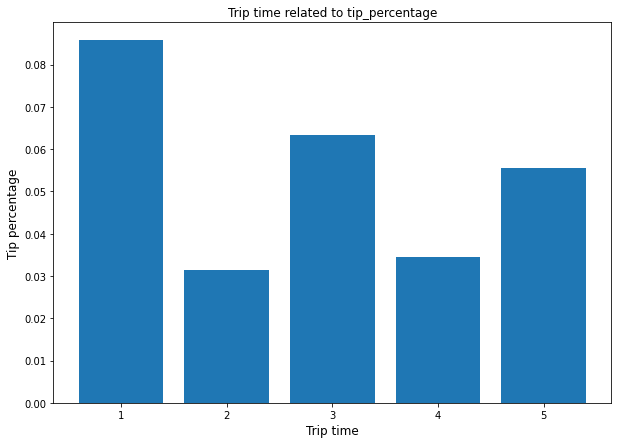

In [ ]:
plt.figure(1,figsize=(10,7))
plt.bar(a0a["label"], a0a["tip_percentage"])
plt.title("Trip time related to tip_percentage")
plt.xlabel("Trip time",fontsize =12)
plt.ylabel("Tip percentage", fontsize =12)

* Scatter Plot

In [ ]:
%%bigquery --project $project_id a1a

SELECT
  TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS time_length,
  tip_amount/fare_amount AS tip_percentage
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` TABLESAMPLE SYSTEM(0.01 PERCENT)
WHERE
  fare_amount IS NOT NULL
  AND fare_amount!=0

Text(0, 0.5, 'Tip percentage')

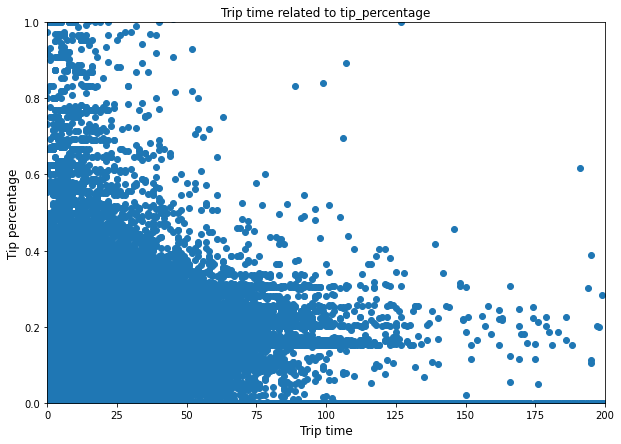

In [ ]:
plt.figure(1,figsize=(10,7))
plt.scatter(a1a["time_length"], a1a["tip_percentage"])
plt.xlim(0,200)
plt.ylim(0,1)
plt.title("Trip time related to tip_percentage")
plt.xlabel("Trip time",fontsize =12)
plt.ylabel("Tip percentage", fontsize =12)

We can see from the above two graphs, the bar plot separate the trip time and the tip percentage, which show us a clearer correlation. 

### 2. Trip Distance vs. Tip Amount

We analyzed the correlation between the distance of trip time and the tip percentage in the *tlc_green_trips_2018* table.

In our query, we grouped by the trip distance type, which was divided into 4 type from 0-2, 2-4, 4-6, and else, and labels them as 1, 2, 3, 4, respectively. 


One possible explanation is that those who choose to take a taxi instead of walking even if the trip distance is veryvery short are those who pursue speed and efficiency and is rich, so they are willing to pay more money to save time and effect, while for those who travel for a long trip distance, they might think the taxi driver is tired for such a long time, thus they paid more. And the remaining part is the normal people who pay the normal tip percentage.

We draw the bar plot and scatter plot to see which can show the more intuitive information.

* Bar Plot

In [ ]:
%%bigquery --project $project_id a9a

SELECT
  (CASE
      WHEN trip_distance BETWEEN 0 AND 2 THEN 1
      WHEN trip_distance BETWEEN 2 AND 4 THEN 2
      WHEN trip_distance BETWEEN 4 AND 6 THEN 3
      ELSE 4
      END
      ) AS label,
    AVG(tip_amount/fare_amount) AS tip_percentage
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` TABLESAMPLE SYSTEM(0.01 PERCENT)
  WHERE
    fare_amount IS NOT NULL
    AND fare_amount !=0
    AND tip_amount/fare_amount < 1
GROUP BY
  label

Text(0, 0.5, 'Tip percentage')

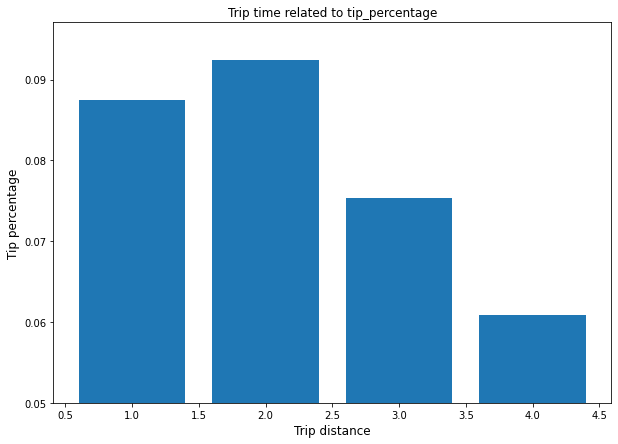

In [ ]:
plt.figure(1,figsize=(10,7))
plt.bar(a9a["label"], a9a["tip_percentage"])
plt.ylim(0.05)
plt.title("Trip time related to tip_percentage")
plt.xlabel("Trip distance",fontsize =12)
plt.ylabel("Tip percentage", fontsize =12)

* Scatter Plot

In [ ]:
%%bigquery --project $project_id a1b

# YOUR QUERY HERE

SELECT
  trip_distance,
  tip_amount/fare_amount AS tip_percentage
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` TABLESAMPLE SYSTEM(0.01 PERCENT)
WHERE
  fare_amount IS NOT NULL
  AND fare_amount!=0

Text(0, 0.5, 'Tip percentage')

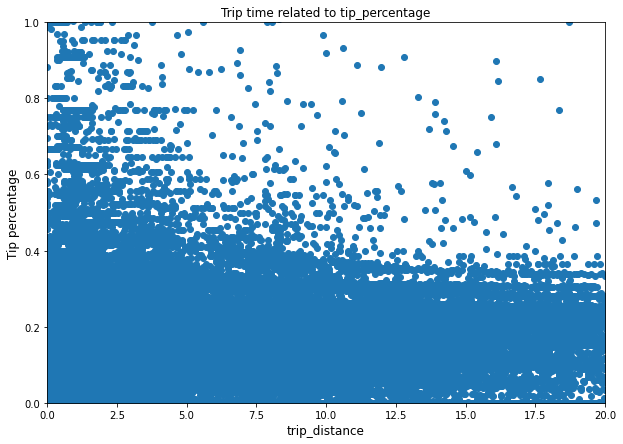

In [ ]:
plt.figure(1,figsize=(10,7))
plt.scatter(a1b["trip_distance"], a1b["tip_percentage"])
plt.xlim(0,20)
plt.ylim(0,1)
plt.title("Trip time related to tip_percentage")
plt.xlabel("trip_distance",fontsize =12)
plt.ylabel("Tip percentage", fontsize =12)

We can see from the above two graphs, the bar plot separate the trip time and the tip percentage, which show us a clearer correlation. 

### 3. Trip Speed vs. Tip Amount


We analyzed the correlation between the speed and the tip percentage in the *tlc_green_trips_2018* table.

In our query, we grouped by the speed, which was divided into 4 types from 0-0.2, 0.2-0.4, 0.4-0.6, and else, and labels them as 1, 2, 3, 4, respectively. 

In the visualization, we can see that with the speed increase, the tip percentage first increase, then decrease. And a speed between 0.2-0.4 has the highest tip percentage. 

One possible explanation is that a low speed probably means there is a traffic congestion or the driver drive a car in slow speed for some reasons, which give the passenger a bad trip experience, while for high speed, the taxi trip may be unsafety and panic for the passenger, thus the tip percentage is also low. The remaining part is those with a proper speed, thus the tip percentage is the highest.

We draw the bar plot and scatter plot to see which can show the more intuitive information.

* Bar Plot

In [ ]:
%%bigquery --project $project_id a8a

SELECT
  (CASE
      WHEN trip_distance/time_length BETWEEN 0 AND 0.2 THEN 1
      WHEN trip_distance/time_length BETWEEN 0.2 AND 0.4 THEN 2
      WHEN trip_distance/time_length BETWEEN 0.4 AND 0.6 THEN 3
      ELSE 4
      END
      ) AS label,
      AVG(a.tip_percentage) AS tip_percentage
FROM (
  SELECT
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS time_length,
    tip_amount/fare_amount AS tip_percentage
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` TABLESAMPLE SYSTEM(0.01 PERCENT)
  WHERE
    fare_amount IS NOT NULL
    AND fare_amount!=0 ) a
WHERE
  time_length IS NOT NULL
  AND time_length != 0
  AND a.tip_percentage < 1
GROUP BY
  label

Text(0, 0.5, 'Tip percentage')

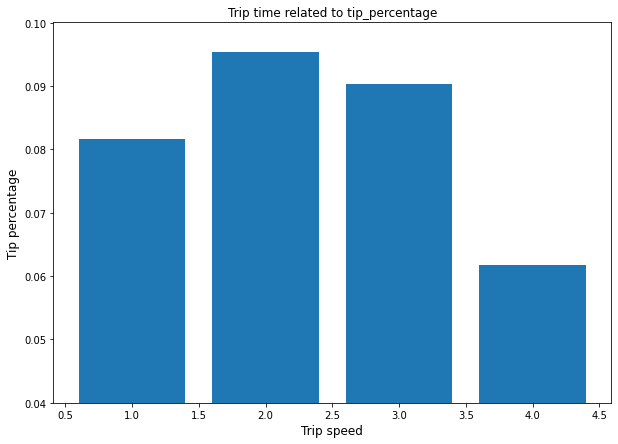

In [ ]:
plt.figure(1,figsize=(10,7))
plt.bar(a8a["label"], a8a["tip_percentage"])
plt.ylim(0.04)
plt.title("Trip time related to tip_percentage")
plt.xlabel("Trip speed",fontsize =12)
plt.ylabel("Tip percentage", fontsize =12)

* Scatter Plot

In [ ]:
%%bigquery --project $project_id a1c

# YOUR QUERY HERE

SELECT
  trip_distance/time_length AS speed,
  a.tip_percentage
FROM (
  SELECT
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS time_length,
    tip_amount/fare_amount AS tip_percentage
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` TABLESAMPLE SYSTEM(0.01 PERCENT)
  WHERE
    fare_amount IS NOT NULL
    AND fare_amount!=0 ) a
WHERE
  time_length IS NOT NULL
  AND time_length != 0

Text(0, 0.5, 'Tip percentage')

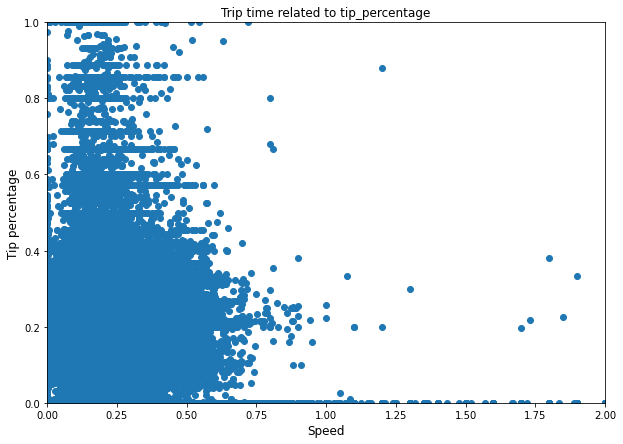

In [ ]:
plt.figure(1,figsize=(10,7))
plt.scatter(a1c["speed"], a1c["tip_percentage"])
plt.xlim(0,2)
plt.ylim(0,1)
plt.title("Trip time related to tip_percentage")
plt.xlabel("Speed",fontsize =12)
plt.ylabel("Tip percentage", fontsize =12)

We can see from the above two graphs, the bar plot separate the trip time and the tip percentage, which show us a clearer correlation. 

### 4. Taxi Color vs. Tip Percent

We Inspected the influence of the genre of taxis on the tip percent, which is indicated by the color of the taxi. As the yellow indicates it is an official taxi and the green indicates it is an street-hail livery.

We used the query to calculate the average tip percent for both taxis respectively in 2018. A visualization of the results is shown below. The average tip percent of the green taxi is around 9% and that of the yellow taxi is around 16% percent. The difference is very significant, which suggests that there is a strong correlation between the taxi color and the tip percent, and it could be a useful feature.

In [ ]:
%%bigquery --project $project_id taxi_color

SELECT "green taxi" as color, ROUND(AVG(tip_amount/fare_amount) * 100, 2) as avg_tip_percent 
FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
WHERE fare_amount is not NULL and fare_amount != 0
UNION ALL 
SELECT "yellow taxi" as color, ROUND(AVG(tip_amount/fare_amount) * 100, 2) as avg_tip_percent 
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018` 
WHERE fare_amount is not NULL and fare_amount != 0

Text(0, 0.5, 'Average Tip Percent')

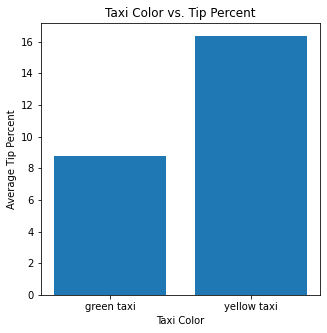

In [ ]:
plt.figure(figsize=(5,5))
plt.bar(taxi_color["color"], taxi_color["avg_tip_percent"])
plt.title("Taxi Color vs. Tip Percent")
plt.xlabel("Taxi Color")
plt.ylabel("Average Tip Percent")

### 5. Pickup Borough and Dropoff Borough vs. Tip Percent

We then tried to see if the regions where the taxis are based make a obvious difference in terms of the tip percent. Because we do not have the travel routes as available information, we decided to only examine the pickup borough and dropoff borough.

To see the relations, we calculated the average tip percent based on the pickup boroughs and dropoff boroughs and order them in increasing order. We found a big rise in the tip percent in the EWR borough as the pickup borough, which is very reasonable, since the drivers are likely to help the passengers with carrying the luggage and other possible errands, which could be highly appreciated by the passengers. And the overall tip percentage is the lowest in boroughs like the Bronx, State Island and Queens.

One thing to notice is that, when we later calculate the tip percentage in the dropoff region sections (details are shown later), we found a few outliers that reaches over 4000% as the tip percentage, which is a very abnormal amount. Hence, we then consider any tip percentage that exceeds 100% to be an outlier. And we inspected the relations both including the outliers and excluding them and show both the results. The overall trend is still obvious, but there is a minor decrease in the difference between consecutive regions. 



In [ ]:
%%bigquery --project $project_id pickup_borough1

SELECT borough, ROUND(AVG(tip_amount/fare_amount) * 100, 2) as avg_tip_percent 
FROM 
    (`bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` trips
    JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` zones
    ON trips.pickup_location_id = zones.zone_id)
WHERE fare_amount is not NULL and fare_amount > 0
GROUP BY borough
ORDER BY avg_tip_percent

Text(0, 0.5, 'Average Tip Percent')

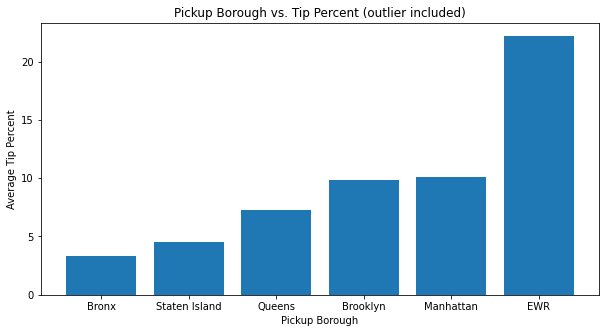

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(pickup_borough1["borough"], pickup_borough1["avg_tip_percent"])
plt.title("Pickup Borough vs. Tip Percent (outlier included)")
plt.xlabel("Pickup Borough")
plt.ylabel("Average Tip Percent")

Based on the findings in the dropoff borough calculation, we decided to perform another query and exclude the outliers this time. And the general relations still remain valid.

In [ ]:
%%bigquery --project $project_id pickup_borough2

SELECT borough, ROUND(AVG(tip_amount/fare_amount) * 100, 2) as avg_tip_percent 
FROM 
    (`bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` trips
    JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` zones
    ON trips.pickup_location_id = zones.zone_id)
WHERE fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1
GROUP BY borough
ORDER BY avg_tip_percent

Text(0, 0.5, 'Average Tip Percent')

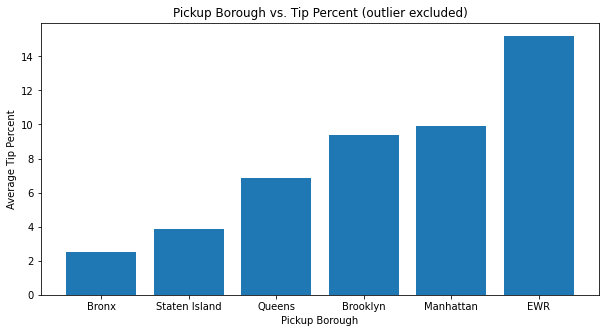

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(pickup_borough2["borough"], pickup_borough2["avg_tip_percent"])
plt.title("Pickup Borough vs. Tip Percent (outlier excluded)")
plt.xlabel("Pickup Borough")
plt.ylabel("Average Tip Percent")

We then inspected the effect of dropoff borough on the average tip percent. There is a abnormally strong correlation, especially for the EWR region. Then we inspected the reason for this abnormality by taking a closer look at the dataset and found out that there are 8 datapoints with tip percentage ranging from 568% to 4600% with the same fare amount of 2.5$, and there the next highest tip percent if 42%, which is much smaller than 568%. So we considered these 8 datapoints at outliers and filtered out all the tip percentage greater than 100% in our later calculations. 

In [ ]:
%%bigquery --project $project_id dropoff_borough1

SELECT borough, ROUND(AVG(tip_amount/fare_amount) * 100, 2) as avg_tip_percent 
FROM 
    (`bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` trips
    JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` zones
    ON trips.dropoff_location_id = zones.zone_id)
WHERE fare_amount is not NULL and fare_amount > 0 
GROUP BY borough
ORDER BY avg_tip_percent

Text(0, 0.5, 'Average Tip Percent')

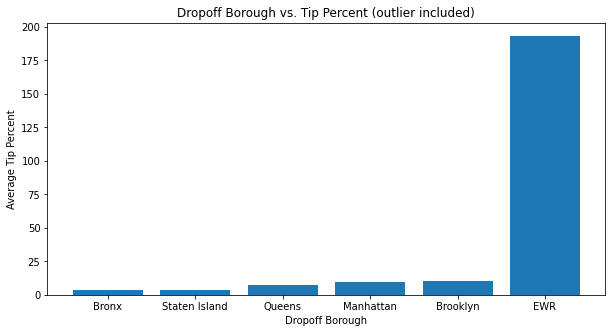

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(dropoff_borough1["borough"], dropoff_borough1["avg_tip_percent"])
plt.title("Dropoff Borough vs. Tip Percent (outlier included)")
plt.xlabel("Dropoff Borough")
plt.ylabel("Average Tip Percent")

The inspection of the dataset for the abnormality is shown below.

In [ ]:
%%bigquery --project $project_id

SELECT borough, ROUND((tip_amount/fare_amount) * 100, 2) percent, tip_amount, fare_amount
FROM 
    (`bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` trips
    JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` zones
    ON trips.dropoff_location_id = zones.zone_id)
where borough = "EWR"
ORDER BY percent DESC
LIMIT 10


,borough,percent,tip_amount,fare_amount
0,EWR,4600,115,2.5
1,EWR,4160,104,2.5
2,EWR,3200,80,2.5
3,EWR,3200,80,2.5
4,EWR,2200,55,2.5
5,EWR,800,20,2.5
6,EWR,680,17,2.5
7,EWR,568,14.2,2.5
8,EWR,42.86,30,70
9,EWR,38.76,25,64.5


After we filtered out the outliers (tip percentage greater than 100%), the results seemed a lot more reasonable. And we could see that there is still a coorelation between dropoff regions and the tip percent, with EWR still being the highest and Bronx the lowest.

In [ ]:
%%bigquery --project $project_id dropoff_borough2

SELECT borough, ROUND(AVG(tip_amount/fare_amount) * 100, 2) as avg_tip_percent 
FROM 
    (`bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` trips
    JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` zones
    ON trips.dropoff_location_id = zones.zone_id)
WHERE fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1
GROUP BY borough
ORDER BY avg_tip_percent

Text(0, 0.5, 'Average Tip Percent')

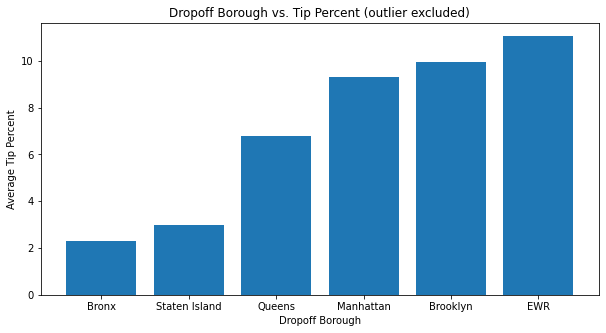

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(dropoff_borough2["borough"], dropoff_borough2["avg_tip_percent"])
plt.title("Dropoff Borough vs. Tip Percent (outlier excluded)")
plt.xlabel("Dropoff Borough")
plt.ylabel("Average Tip Percent")

### 6. Passenger Count vs. Tip Percent


We also wanted to see if the number of passengers could affect the tip percent of a taxi trip for any possible social or psychlogical reasons. We grouped the trips by the number of passengers per trip and calculated the average tip percentage. A visualization is shown below.

There is not a visible trend of their correlations as the variation of tip percent versus the passenger count is pretty random.

In [ ]:
%%bigquery --project $project_id passenger_count

SELECT passenger_count, ROUND(AVG(tip_amount/fare_amount) * 100, 2) as avg_tip_percent
FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` trips
WHERE fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1
GROUP BY passenger_count

Text(0, 0.5, 'Average Tip Percent')

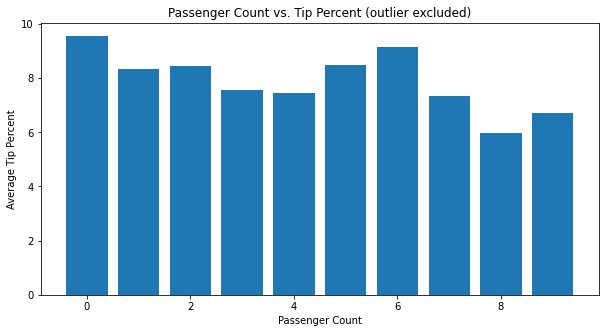

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(passenger_count["passenger_count"], passenger_count["avg_tip_percent"])
plt.title("Passenger Count vs. Tip Percent (outlier excluded)")
plt.xlabel("Passenger Count")
plt.ylabel("Average Tip Percent")

### 7. Season vs. Tip Percent

Since season is usually a very important part of business, especially in the service industries, we determined it to be a potentially powerful feature. Fortunately, the dataset contains the pickup_time for the trip, which is enough information for us to determine the season when each trip happens. We split the dataset into 4 seasons based on the dates and calculated the average tip percentage for each season. A visualization of the results is shown below.

The average tip percent increases in the order of summer, fall, spring, winter, which exactly corresponded to the temperature of these four seasons in decreasing order. Therefore, such variations could be attributed to the weather. As the weather becomes colder, passengers are more likely to appreciate the warm environments of taxis and therefore tend to tip higher. 

In [ ]:
%%bigquery --project $project_id season

SELECT
(CASE
WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
ELSE "Winter"
END) AS season, ROUND(AVG(tip_amount/fare_amount) * 100, 2) as avg_tip_percent
FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` trips
WHERE fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1
GROUP BY season

Text(0, 0.5, 'Average Tip Percent')

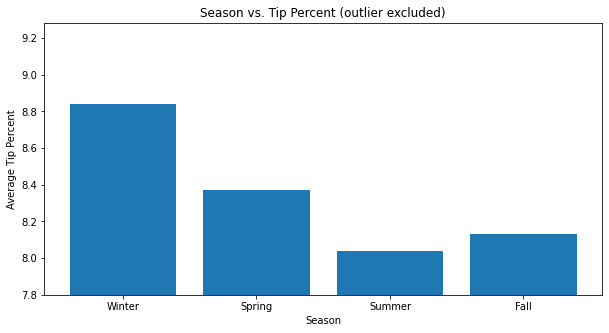

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(season["season"], season["avg_tip_percent"])
plt.title("Season vs. Tip Percent (outlier excluded)")
plt.ylim(7.8)
plt.xlabel("Season")
plt.ylabel("Average Tip Percent")

### 8. Trip Type vs. Tip Percent

Finally we considered the feature of trip type. The dataset have 2 different trip types, which are "Street-hail" and "Dispatch".

We calculated the average tip percentage of two different types of trips, the results show that the average tip percentage (around 8%) for the "Street-hail" type trip is much higher than that of the "Dispatch" type (around 2%). Therefore, we consider it as a potential feature for the prediction.

In [ ]:
%%bigquery --project $project_id trip_type

SELECT
(CASE
WHEN trip_type = "1" THEN "Street-hail"
ELSE "Dispatch"
END) AS trip_type, ROUND(AVG(tip_amount/fare_amount) * 100, 2) as avg_tip_percent
FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` trips
WHERE trip_type is not NULL and 
      fare_amount is not NULL and fare_amount > 0 and 
      tip_amount/fare_amount < 1
GROUP BY trip_type

Text(0, 0.5, 'Average Tip Percent')

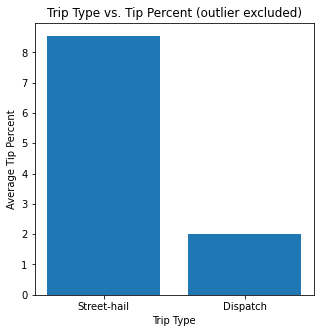

In [ ]:
plt.figure(figsize=(5,5))
plt.bar(trip_type["trip_type"], trip_type["avg_tip_percent"])
plt.title("Trip Type vs. Tip Percent (outlier excluded)")
plt.xlabel("Trip Type")
plt.ylabel("Average Tip Percent")

---
# Data Prediction
---


In this section we tried two types of models: a regression model that predicts a numerical results and a classifier that divides the tip percent into 2 catogories "High" and "Low" with a threshold of 5%.

For the numerical model, we used the metric of Mean Absolute Error, and for the classifier, we adopted the metrics of Accuracy and Precision.

### Feature Selection

According to the Data Exploration section, out of all the features we inspected, the ones that have a corelation with the tip percentage are:

1.   Trip Time
2.   Trip Distance
3.   Trip Speed
4.   Pickup Borough
5.   Dropoff Borough
6.   Taxi Color
7.   Season
8.   Trip Type


Because the overall dataset is enormous, we limited our prediction to only the green taxis, so we excluded **5. Taxi Color** from our feature selection. 
Since we can calculate the any one of the features from **1. Trip Time 2. Trip Distance 3. Trip Speed** once we have any two of them, we decided to exclude the **1. Trip Time** because the trend identified in its visualization is more complex and vague, which might not be helpful for the predictions. Moreover, the **3. Pickup Borough** and **4. Dropoff Borough** produce very similar trends, we will only considered one of these two features to cut off unnecessary calculations for the model. After comparing the graphs corresponding to both of the features, we decided that the **3. Pickup Borough** had a higher predicting power, so this feature is chosen.

After removing 2 uncessary features, the model will include 5 features for predictions:

1.   Trip Distance
2.   Trip Speed
3.   (Pickup) Borough
4.   Season
5.   Trip Type



### Data Split

We splited the data around the afternoon time into training, validation and test set based on the pickup time of each trip. We selected the training data range to be from 13:00 -14:00, the validation range to be from 14:00 -15:00, and the test range to be from 15:00 -16:00.

For the prediction on unseen data, we considered the data after 20:00. Because all of the data the model seen was from the afternoon, it did not contain any information about the tip percentage in the night. And we checked the performance of the model at night in the prediction section.

### Create a dataset to store the model

In [ ]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'NY_taxi_tip'
dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Conflict: ignored

## **Regression Model**

### Data Overview


In [ ]:
# Extract training data from dataset

%%bigquery --project $project_id

SELECT tip_percent, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` LIMIT 100000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    ROUND(tip_amount/fare_amount * 100, 2) as tip_percent,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 
LIMIT 10

,tip_percent,trip_type,season,borough,trip_distance,trip_speed
0,20.98,1,Winter,Brooklyn,8.71,0.414761905
1,0,1,Winter,Queens,10.46,0.581111111
2,0,1,Winter,Manhattan,6.87,0.221612903
3,5.92,1,Winter,Manhattan,13.8,0.575
4,0,1,Winter,Brooklyn,17.59,0.43975
5,10.48,1,Winter,Manhattan,7.65,0.255
6,0,1,Winter,Brooklyn,12.44,0.460740741
7,20.57,1,Winter,Queens,8.46,0.313333333
8,0,1,Winter,Brooklyn,12.45,0.478846154
9,0,1,Winter,Brooklyn,7.15,0.238333333


---
## Linear Regression
---
We started our training with the linear regression model, and the label was tip_percentage. (We want to use linear regression because we are predicting a continuous quantity, i.e percentage.)
This led to some results, as we will discuss later.



### Training

In [ ]:
# Train the model

%%bigquery --project $project_id
CREATE OR REPLACE MODEL `NY_taxi_tip.numerical_model1`
OPTIONS(model_type='linear_reg') AS
SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
          WHERE EXTRACT(HOUR FROM pickup_datetime) = 13 
          LIMIT 10000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    ROUND(tip_amount/fare_amount * 100, 2) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 

""


In [ ]:
# Training stats
%%bigquery --project $project_id

SELECT *
FROM
  ML.TRAINING_INFO(MODEL `NY_taxi_tip.numerical_model1`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,69.151531,78.755725,None,2734


### Validation

In [ ]:
# Evaluation ! :)
%%bigquery --project $project_id

SELECT *
FROM
  ML.EVALUATE(MODEL `NY_taxi_tip.numerical_model1`, (
SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
          WHERE EXTRACT(HOUR FROM pickup_datetime) = 14 
          LIMIT 10000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    ROUND(tip_amount/fare_amount * 100, 2) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 ))


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,6.663783,76.62542,2.501031,5.58065,0.053832,0.054034



Through evaluating our linear regression ML model, we see that the mean_absolute_error is 6.663783. This error suggests that in average, our prediction is around 6.67% away from the true tip percentage.

We are unsure about whether this results is relatively reasonable, so we chose another model DNN to and compare the results obtained from both models to get a more comprehensive idea. 

### Test

The metrics of mean absolute error increases from 6.67 to 6.97. This overall drop in the performance can be justified by the way we split the dataset. The time slot of the training set starts at 13:00, which is closer to the 14:00 of the validation set than the 15:00 of the testing dataset, which could give rise to a difference in the calculation of tips. 

In [ ]:
# Test
%%bigquery --project $project_id

SELECT *
FROM
  ML.EVALUATE(MODEL `NY_taxi_tip.numerical_model1`, (
SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
          WHERE EXTRACT(HOUR FROM pickup_datetime) = 15 
          LIMIT 10000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    ROUND(tip_amount/fare_amount * 100, 2) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 ))


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,6.968911,78.791258,2.493454,5.772814,0.058879,0.059246


### Prediction

In [ ]:
# Prediction
%%bigquery --project $project_id
SELECT
  predicted_label, 
  label,
  trip_type, 
  season, 
  borough, 
  trip_distance, 
  trip_speed
FROM
  ML.PREDICT(MODEL `NY_taxi_tip.numerical_model1`,
(SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
           WHERE EXTRACT(HOUR FROM pickup_datetime) > 20
          LIMIT 10000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    ROUND(tip_amount/fare_amount * 100, 2) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 ))


,predicted_label,label,trip_type,season,borough,trip_distance,trip_speed
0,6.005349,0,1,Summer,Staten Island,22.93,0.603421053
1,0.985573,21.7,2,Spring,Staten Island,23.49,0.559285714
2,6.798414,24.92,1,Summer,Staten Island,18.91,0.61
3,5.704950,0,1,Summer,Staten Island,19.94,0.486341463
4,4.539665,0,1,Spring,Staten Island,26.01,0.464464286
...,...,...,...,...,...,...,...
9155,7.556178,33.45,1,Summer,Manhattan,8.3,0.267741935
9156,8.071260,20.87,1,Summer,Manhattan,9.76,0.375384615
9157,6.702710,0,1,Summer,Manhattan,18.91,0.420222222
9158,7.946372,25.94,1,Summer,Manhattan,10.7,0.382142857


We included the features and the original/predicted labels in the prediction. The predicted tip percentage is not very close to the actual labels from the limited examples shown in the table. However, the general trend is reasonable, which means that for higher original tip percentage, the predictions tend to be higher as well.

---
## Deep Neural Network
---

Because we only use linear regression model to predict, we don't have a comparative model to evaluate whether it's good, so we tried another model, Deep Neural Network (DNN) in an attempt to use a more complex machine learning approach.

### Training

In [ ]:
# Train the model
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `NY_taxi_tip.numerical_model2`
OPTIONS(model_type='DNN_REGRESSOR') AS
SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
          WHERE EXTRACT(HOUR FROM pickup_datetime) = 13 
          LIMIT 10000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    ROUND(tip_amount/fare_amount * 100, 2) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 

""


In [ ]:
# Training stats
%%bigquery --project $project_id

SELECT *
FROM
  ML.TRAINING_INFO(MODEL `NY_taxi_tip.numerical_model2`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,27.521572,79.070985,0.000615,29314
1,0,0,22.359638,81.950651,0.000460,18344


### Validation

In [ ]:
# Evaluation ! :)
%%bigquery --project $project_id

SELECT *
FROM
  ML.EVALUATE(MODEL `NY_taxi_tip.numerical_model2`, (
SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
          WHERE EXTRACT(HOUR FROM pickup_datetime) = 14 
          LIMIT 10000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    ROUND(tip_amount/fare_amount * 100, 2) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 ))


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,6.851136,77.915481,2.421413,5.304399,0.066332,0.066683


The mean_absolute_error is approximately the same as this for the linear regression ML model and even increased a little from 6.67 to 6.85. 

### Test
The mean_absolute_error is higher for the test dataset compared to the validation set as expected, for the same possible reason discussed in the linear regression model.

In [ ]:
# Test
%%bigquery --project $project_id

SELECT *
FROM
  ML.EVALUATE(MODEL `NY_taxi_tip.numerical_model2`, (
SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
          WHERE EXTRACT(HOUR FROM pickup_datetime) = 15 
          LIMIT 10000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    ROUND(tip_amount/fare_amount * 100, 2) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 ))


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,7.082958,77.61926,2.643458,5.500946,0.042356,0.043612


### Prediction

In [ ]:
# Prediction
%%bigquery --project $project_id

SELECT
  predicted_label, 
  label,
  trip_type, 
  season, 
  borough, 
  trip_distance, 
  trip_speed
FROM
  ML.PREDICT(MODEL `NY_taxi_tip.numerical_model2`,
(SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
           WHERE EXTRACT(HOUR FROM pickup_datetime) > 20
          LIMIT 10000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    ROUND(tip_amount/fare_amount * 100, 2) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 ))


,predicted_label,trip_type,season,borough,trip_distance,trip_speed
0,5.385071,1,Fall,EWR,15.14,0.420555556
1,0.765212,2,Fall,EWR,17.62,0.33245283
2,4.121010,1,Fall,Bronx,9.86,0.410833333
3,4.470576,1,Fall,Bronx,8.15,0.428947368
4,0.328964,2,Fall,Bronx,20.2,0.517948718
...,...,...,...,...,...,...
9171,5.542766,1,Winter,Staten Island,17.86,0.541212121
9172,4.247650,1,Winter,Staten Island,28.66,0.530740741
9173,5.880517,1,Winter,Staten Island,16.7,0.575862069
9174,6.792374,1,Winter,Staten Island,11.8,0.59


The prediction results seems to be similar to those of the linear regression model.

## **Classification Model**

Predicting a specific tip percentage using normal regression might not be a optimal task for the dataset we've chosen to work with. Therefore, we tried another classification model.

### Data Overview

After finishing the linear regression and deep neural network regression model, we deicided to explore another direction, where we could label the tip percentage below or equal to 5% to be "0" and the tip percentage above 5% to be "1" and build a classifier instead of a numeric predictor. An overview of the data selected is shown below. The features we included are exactly the same as the previous 2 regression models. The only difference is the "label" field, where we represent the tip percentages as "1" and "0" respectively.

In [ ]:
%%bigquery --project $project_id

SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` LIMIT 100000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    IF(tip_amount/fare_amount > 0.05, 1, 0) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 
LIMIT 10


,label,trip_type,season,borough,trip_distance,trip_speed
0,1,1,Winter,Brooklyn,8.71,0.414761905
1,0,1,Winter,Queens,10.46,0.581111111
2,0,1,Winter,Manhattan,6.87,0.221612903
3,1,1,Winter,Manhattan,13.8,0.575
4,0,1,Winter,Brooklyn,17.59,0.43975
5,1,1,Winter,Manhattan,7.65,0.255
6,0,1,Winter,Brooklyn,12.44,0.460740741
7,1,1,Winter,Queens,8.46,0.313333333
8,0,1,Winter,Brooklyn,12.45,0.478846154
9,0,1,Winter,Brooklyn,7.15,0.238333333


---
# Logistic Regression 
---

### Training

We started building this classifier with the classic logistic regression model. Since training a classifier with only 2 possible labels is much less costly than training a numeric predictor, we included more training data (still in the range 13:00 to 14:00 in terms of time, which is consistent with our overall dataset division strategy) for this model (500000 datapoints compared to the previou 10000) with the hope that they can improve the overall accuracy of the model.

The setup of the model and the training information are shown as below. The training loss decreases from the initial 0.66 to the final 0.58.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `NY_taxi_tip.classification_model1` -- we'll call our model 'bikeshare_model'
OPTIONS (model_type='logistic_reg') AS
SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
           WHERE EXTRACT(HOUR FROM pickup_datetime) = 13
           LIMIT 500000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    IF(tip_amount/fare_amount > 0.05, 1, 0) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 

""


In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `NY_taxi_tip.classification_model1`)
ORDER BY iteration

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.662775,0.663440,0.2,6558
1,0,1,0.626666,0.628377,0.4,7970
2,0,2,0.601810,0.604717,0.8,7899
3,0,3,0.592283,0.595564,1.6,8190
4,0,4,0.586074,0.588449,3.2,8145
5,0,5,0.584561,0.587376,1.6,7452


### Validation

Then we evaluate our model using our validation dataset. The accuracy and the precision of the model are around 0.69 and 0.59 for the validation, which is a relatively reasonable and acceptable result. 

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `NY_taxi_tip.classification_model1`,
(SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
           WHERE EXTRACT(HOUR FROM pickup_datetime) = 14
           LIMIT 100000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    IF(tip_amount/fare_amount > 0.05, 1, 0) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.590361,0.001615,0.694652,0.00322,0.588615,0.639728


### Test

Then we evaluate the model on the test dataset. The accuracy of the model decreases to around 0.66 previous 0.69, but the precision of the model increases to 0.67 compared to 0.59. The drop in performance could be justified with the same reason we discussed in the numeric model sections. However, the overall performance discrepancy is not very big and when evaluated on the testing dataset, the model is still decent.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `NY_taxi_tip.classification_model1`,
(SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
           WHERE EXTRACT(HOUR FROM pickup_datetime) = 15
           LIMIT 100000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    IF(tip_amount/fare_amount > 0.05, 1, 0) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.662791,0.001774,0.677175,0.003538,0.606212,0.634092


### Prediction

Overall, the training, validation and testing dataset are all selected in the time of afternoon, so the model does not seen any information about the tip percentage in the night. Therefore, we used the time after 20:00 for the prediction section.

Part of the prediction is shown in the table below. The table included the original label, predicted label and all the features we used in the model. The predictions shown is reasonable, as about 70% of the predictions are correct, which agrees with our previous evaluations.

In [ ]:
%%bigquery --project $project_id

SELECT
  predicted_label, label, trip_type, season, borough, trip_distance, trip_speed
FROM
  ML.PREDICT(MODEL `NY_taxi_tip.classification_model1`,
(SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
           WHERE EXTRACT(HOUR FROM pickup_datetime) > 20
           LIMIT 1000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    IF(tip_amount/fare_amount > 0.05, 1, 0) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0))
LIMIT 100

,predicted_label,label,trip_type,season,borough,trip_distance,trip_speed
0,0,1,1,Winter,Queens,11.93,0.322432432
1,0,0,1,Winter,Queens,14.07,0.781666667
2,0,0,1,Winter,Queens,8.2,0.205
3,0,1,1,Winter,Brooklyn,8.87,0.466842105
4,0,0,1,Winter,Queens,14.4,0.351219512
...,...,...,...,...,...,...,...
95,0,0,1,Spring,Manhattan,11.1,0.37
96,0,1,1,Spring,Brooklyn,8.75,0.35
97,0,0,1,Spring,Bronx,11.2,0.4
98,0,1,1,Spring,Manhattan,7.23,0.267777778


---
# Boosted_tree_classifier
---

### Training

To further improve the performance of our model, we tried another model type provided by BigQuery, the Boosted Tree Classifier, with all the other setups being exactly the same as the previous model. 

The ultimate training loss decreases from the 0.58 in the logistic regression model to 0.57, which is a improvement.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `NY_taxi_tip.classification_model2` -- we'll call our model 'bikeshare_model'
OPTIONS (model_type='boosted_tree_classifier') AS
SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
           WHERE EXTRACT(HOUR FROM pickup_datetime) = 13
           LIMIT 500000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    IF(tip_amount/fare_amount > 0.05, 1, 0) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0 

""


In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `NY_taxi_tip.classification_model2`)
ORDER BY iteration

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,0.635364,0.635714,0.3,165207
1,0,2,0.604971,0.606205,0.3,44
2,0,3,0.588028,0.589734,0.3,52
3,0,4,0.578623,0.580408,0.3,13181
4,0,5,0.572537,0.574698,0.3,39


### Validation

When evaluated on the validation dataset, the accuracy and precision are around 0.7 and 0.55. Compared to the Logistic Regression model, there is a increase in accuracy but a decrease in the precision.


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `NY_taxi_tip.classification_model2`,
(SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
           WHERE EXTRACT(HOUR FROM pickup_datetime) = 14
           LIMIT 100000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    IF(tip_amount/fare_amount > 0.05, 1, 0) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.549883,0.138356,0.700062,0.221085,0.577258,0.671906


### Testing

When evaluated on the testing set, the overall performance dropped (0.68 accuracy and 0.54 precision) compared to the validation set (0.70 accuracy and 0.55 precision), for the possible reasons that we discussed about in the Logistic Regression model.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `NY_taxi_tip.classification_model2`,
(SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
           WHERE EXTRACT(HOUR FROM pickup_datetime) = 15
           LIMIT 100000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    IF(tip_amount/fare_amount > 0.05, 1, 0) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.544685,0.116756,0.684774,0.192293,0.591295,0.661383


### Prediction

Similarly we used the model built with Boosted Tree Classfier to predict the tip percentage at night. Again, the overall prediction is very reasonable.

In [ ]:
%%bigquery --project $project_id

SELECT
  predicted_label, label, trip_type, season, borough, trip_distance, trip_speed
FROM
  ML.PREDICT(MODEL `NY_taxi_tip.classification_model2`,
(SELECT label, trip_type, season, borough, trip_distance, (trip_distance/trip_length) as trip_speed
FROM (
WITH T AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018` 
           WHERE EXTRACT(HOUR FROM pickup_datetime) > 20
           LIMIT 1000),
     Z AS (SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT
    IF(tip_amount/fare_amount > 0.05, 1, 0) as label,
    trip_type,
    (CASE
    WHEN pickup_datetime BETWEEN "2018-03-20" And "2018-06-20" THEN "Spring"
    WHEN pickup_datetime BETWEEN "2018-06-22" And "2018-09-21" THEN "Summer"
    WHEN pickup_datetime BETWEEN "2018-09-22" And "2018-12-22" THEN "Fall"
    ELSE "Winter"
    END) AS season,
    borough,
    trip_distance,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime, minute) AS trip_length,
FROM 
    (T JOIN Z ON T.pickup_location_id = Z.zone_id)
 WHERE
    fare_amount is not NULL and fare_amount > 0 and tip_amount/fare_amount < 1)   
WHERE trip_length IS NOT NULL AND trip_length != 0))
LIMIT 100

,predicted_label,label,trip_type,season,borough,trip_distance,trip_speed
0,0,0,1,Winter,Queens,13.97,0.635
1,0,0,1,Winter,Queens,17.17,0.5365625
2,0,0,1,Winter,Brooklyn,8.89,0.3175
3,0,0,2,Winter,Manhattan,3.49,0.290833333
4,0,1,1,Winter,Brooklyn,9.4,0.447619048
...,...,...,...,...,...,...,...
95,0,0,1,Spring,Manhattan,10.37,0.235681818
96,1,1,1,Spring,Manhattan,7.46,0.286923077
97,0,0,1,Spring,Manhattan,6.19,0.143953488
98,1,1,1,Spring,Manhattan,7.6,0.2


# Conclusion

---

To address the problem of exploring the correlations of trip characteristics with tip percentage, which is closely related to the customer experience, We overall considered **travel distance**, **travel time** which are the two very basic but essential aspects of a taxi trip. However, they certainly do not cover everything about a taxi trip, as they are very closely related to each other. Therefore, we engineered two extra features potentially related to customer experience: **travel speed** and **travel season**. Besides these features that might manifest the more subjective parts of a trip, we also explored some more objective features, such as the **pickup/dropoff borough**, **trip type**, **taxi type** and the **number of passengers**.

To check if any correlation exists, we generally adopted the strategy of calcualting the average tip percentage for categories based on the feature we've chosen. For example, for the **travel season** feature, we divided the trips into 4 seasons and used the query to get the average tip percentage of each season. For numerical features that can not be easily categorized, we used both scatter plots and bar plots with ranges.

A general summary of the exploration results of our features is shown below.

**Features with porential correlations:**

1. Trip Time: There is a obvious bell shape formed by the bars in the visualization
2. Trip Distance: The overall tip percentage decreases with distance in the visualization
3. Trip Speed: Tip percentage increases when the trip speed increase, but when the speed is too fast, the tip decreases, possibly due to safety reasons.
4. Trip Color: Tip percentage of yellow taxis is much higher on average than that of green taxis shown in the visualization.
5. Pickup/Dropoff Borough: The boroughs make a very big difference on the average tip percentage, as evident in the visualizations.
6. Trip Season: The average tip percent increases as the temperature decreases with season variations.
7. Trip Type: The average "Street-Hail" tip is much higher than that of the "Dispatch" shown in the visualization

**Features without porential correlations:**
1. Number of Passengers: There is no obvious trend observed in the visualization

To adjust the scope of prediction to a proper size, we limited the number of features to be 5 and the training data to 10000 and 500000 for the regression and classification models respectively, which was discussed in more detail in the prediction section. We were able to achieve a Mean Absolute Error around 6 - 7 for the regression models and an Accuracy around 70% for the classification models, which is a decent performance considering the number of data points we used, which is also a good evidence that the features we selected are very likely to be correlated with the tip percentage. 

Even though the overall result of this project is reasonable, there are still several abberations in the dataset, such as the abnormally high tip percentage in some trips. Although we were able to spot and take care of this problem during the data exploration stage, we cannot guarantee similar problems do not exist in other features we used. Tip percentage is a very actually a very random subject, it could be affected by lots of other factors, like the passengers' mood, the talk they had during the trip, the financial states of the passengers. The dataset we adopted does not contain information that is able to manifest these aspects. 

There are also some future works that we identified to be worth doing during the project. For example, since we wanted to explore the effect of seasons, we could not divide the dataset by month. Instead we divided the dataset by the time in a day, which could possibly lead to a unevenly distributed dataset. We could try to split the data within each season and combine them together or use random sampling, but due to the time limit, we did not perform such trials. Since the dataset is very big with several millions of datapoints in total, we were only able to use a small part of that given the training time and power, which could also lead to undersampling, and we can improve on that in possible future works.



---